## Load Data

In [ ]:
# Mount drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# code taken from https://www.cl.cam.ac.uk/research/nl/bea2019st/data/corr_from_m2.py
def m2_to_df(m2, id):
    # Do not apply edits with these error types
    skip = {"noop", "UNK", "Um"}
    ori_sentences = []
    corrected_sentences = []
    errors = []
    for sent in m2:
        sent_errors = []
        sent = sent.split("\n")
        ori_sent = sent[0].split()[1:] # Ignore "S "
        cor_sent = ori_sent.copy()
        edits = sent[1:]
        offset = 0
        for edit in edits:
            edit = edit.split("|||")
            sent_errors.append(edit[1])
            if edit[1] in skip: continue # Ignore certain edits
            coder = int(edit[-1])
            if coder != id: continue # Ignore other coders
            span = edit[0].split()[1:] # Ignore "A "
            start = int(span[0])
            end = int(span[1])
            cor = edit[2].split()
            cor_sent[start+offset:end+offset] = cor
            offset = offset-(end-start)+len(cor)
        ori_sentences.append(" ".join(ori_sent))
        corrected_sentences.append(" ".join(cor_sent))
        errors.append(sent_errors)
    df = pd.DataFrame(list(zip(ori_sentences, corrected_sentences, errors)),columns =["original", "corrected", "errors"])
    return df

In [ ]:
# To add a shortcut to your own google drive
# Go to https://drive.google.com/drive/folders/1ev3EJspBmUlQk4QtpZbYP9Ct02pvxpgy
# Right click the top "CS4248NLP" button > Organize > Add Shortcut > My Drive
with open("/content/drive/MyDrive/CS4248NLP/wi+locness/m2/ABC.train.gold.bea19.m2") as f:
    m2_train = f.read().strip().split("\n\n")
    train_df = m2_to_df(m2_train, 0)

In [ ]:
train_df.sample(5)

,original,corrected,errors
25613,There are currently 9 desserts offered on the ...,There are currently 9 desserts offered on the ...,"[M:PUNCT, M:PUNCT]"
30765,"Moreover , she has been to a camp in Australia...","Moreover , she has been to a camp in Australia...",[noop]
10056,Another thing we can do to a better future is ...,Another thing we can do for a better future is...,[R:PREP]
21382,I am writing in connection with the advertisem...,I am writing in connection with the advertisem...,[noop]
26749,"But , thanks to mom , I feel much better now .","But , thanks to mom , I feel much better now .",[noop]


In [ ]:
print("First sentence")
print(train_df.loc[0]["original"])
print(train_df.loc[0]["corrected"])

First sentence
My town is a medium size city with eighty thousand inhabitants .
My town is a medium - sized city with eighty thousand inhabitants .


## Char & Word Count

In [ ]:
train_df["original_char_count"] = train_df["original"].astype("str").apply(lambda x:len(x))
train_df["corrected_char_count"] = train_df["corrected"].astype("str").apply(lambda x:len(x))

train_df["original_word_count"] = train_df["original"].astype("str").apply(lambda x:len(x.split()))
train_df["corrected_word_count"] = train_df["corrected"].astype("str").apply(lambda x:len(x.split()))

In [ ]:
train_df["original_char_count"].describe()

count    34308.000000
mean        91.170981
std         62.217687
min          1.000000
25%         50.000000
50%         80.000000
75%        118.000000
max       1094.000000
Name: original_char_count, dtype: float64

In [ ]:
train_df["corrected_char_count"].describe()

count    34308.000000
mean        92.153579
std         63.199013
min          0.000000
25%         51.000000
50%         80.000000
75%        119.000000
max       1152.000000
Name: corrected_char_count, dtype: float64

In [ ]:
train_df["original_word_count"].describe()

count    34308.000000
mean        18.325755
std         12.047844
min          1.000000
25%         11.000000
50%         16.000000
75%         23.000000
max        220.000000
Name: original_word_count, dtype: float64

In [ ]:
train_df["corrected_word_count"].describe()

count    34308.000000
mean        18.686866
std         12.444891
min          0.000000
25%         11.000000
50%         16.000000
75%         24.000000
max        236.000000
Name: corrected_word_count, dtype: float64

In [ ]:
def plot_scatter(title, x, y, x_label, y_label):
    fig, axs = plt.subplots(figsize=(5,5))

    axs.scatter(x, y, marker=".")
    line = mlines.Line2D([0, 1], [0, 1], color="black",linestyle=":",label="Normal Line")
    transform = axs.transAxes
    line.set_transform(transform)
    axs.add_line(line)
    axs.set_ylabel(y_label)
    axs.grid()
    axs.set_xlabel(x_label)
    axs.annotate(f"Correlation Score:{round((np.corrcoef(x,y)[0][1]),4)}", xy=(0.7, 0.5), xycoords="axes fraction",
                 bbox=dict(boxstyle="round", fc="none", ec="gray"), xytext=(10, -40), textcoords="offset points", ha="center", fontsize=10)
    plt.title(title)
    plt.show()

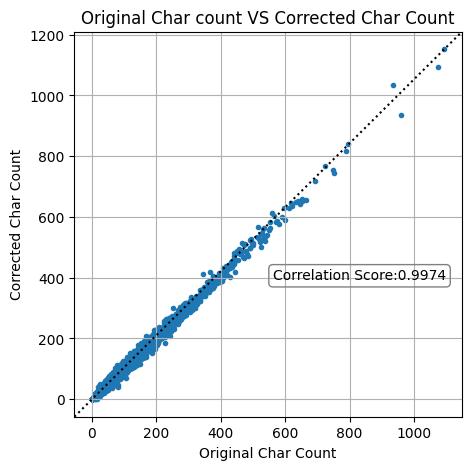

In [ ]:
plot_scatter("Original Char count VS Corrected Char Count", train_df["original_char_count"], train_df["corrected_char_count"], "Original Char Count", "Corrected Char Count")

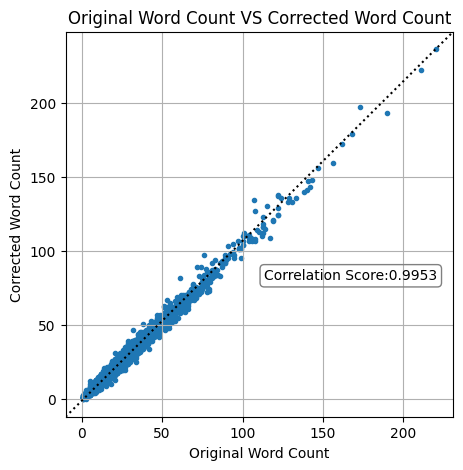

In [ ]:
plot_scatter("Original Word Count VS Corrected Word Count", train_df["original_word_count"], train_df["corrected_word_count"], "Original Word Count", "Corrected Word Count")

## Ngram Count

In [ ]:
def get_ngram_freq(n, sentences):
    ngram_count_vectorizer = CountVectorizer(ngram_range=(n, n))
    ngram_count_vec = ngram_count_vectorizer.fit_transform(sentences)
    ngram_counts = ngram_count_vec.sum(axis=0).reshape(-1)
    word_freqs = [(word, ngram_counts[0, idx]) for idx, word in enumerate(ngram_count_vectorizer.get_feature_names_out())]
    df = pd.DataFrame(word_freqs, columns =["ngram", "freq"])
    df = df.sort_values(by=["freq"],ascending=[False])
    return df

def plot_ngram_freq(df, title, top_n):
    df = df[:top_n]
    fig, ax = plt.subplots(figsize=(15, 8))
    ax = sns.barplot(data=df, x="freq", y="ngram")
    ax.tick_params(labelsize=8)
    for bar in ax.patches:
        ax.annotate(int(bar.get_width()), (bar.get_width(), bar.get_y() + bar.get_height()/2), size=8, ha="left", va="center")
    plt.title(title)
    plt.show()

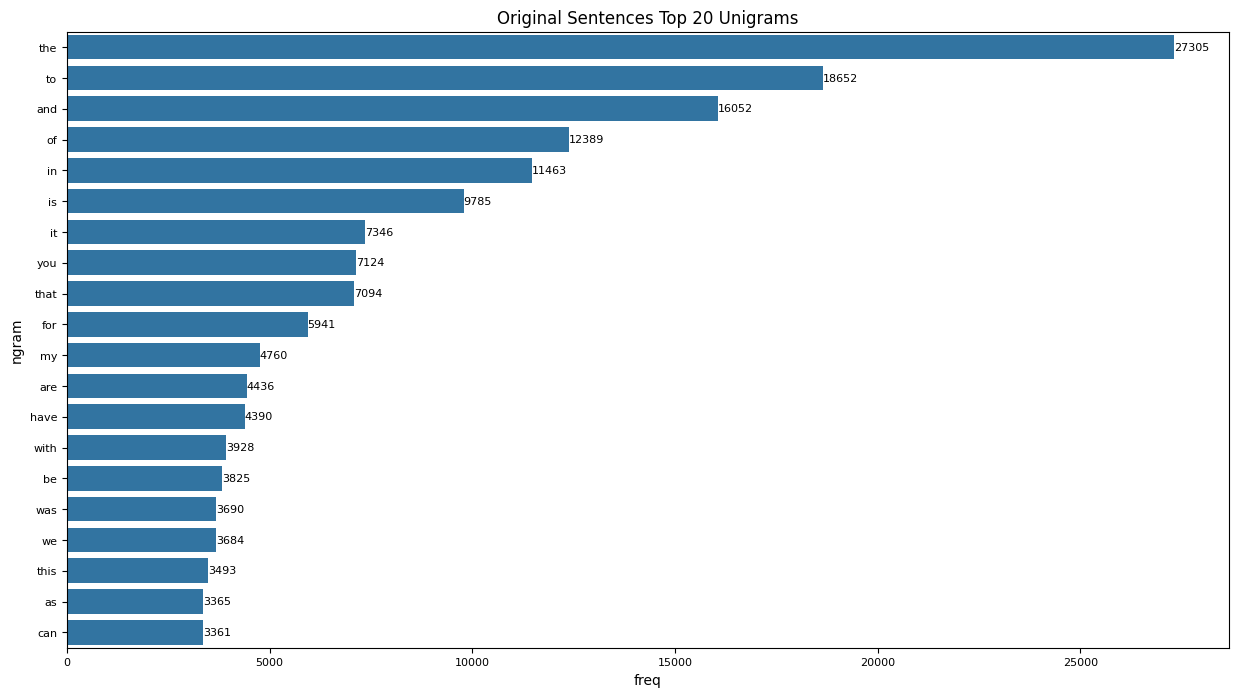

In [ ]:
train_ori_unigram_df = get_ngram_freq(1, train_df["original"])
plot_ngram_freq(train_ori_unigram_df, "Original Sentences Top 20 Unigrams", 20)

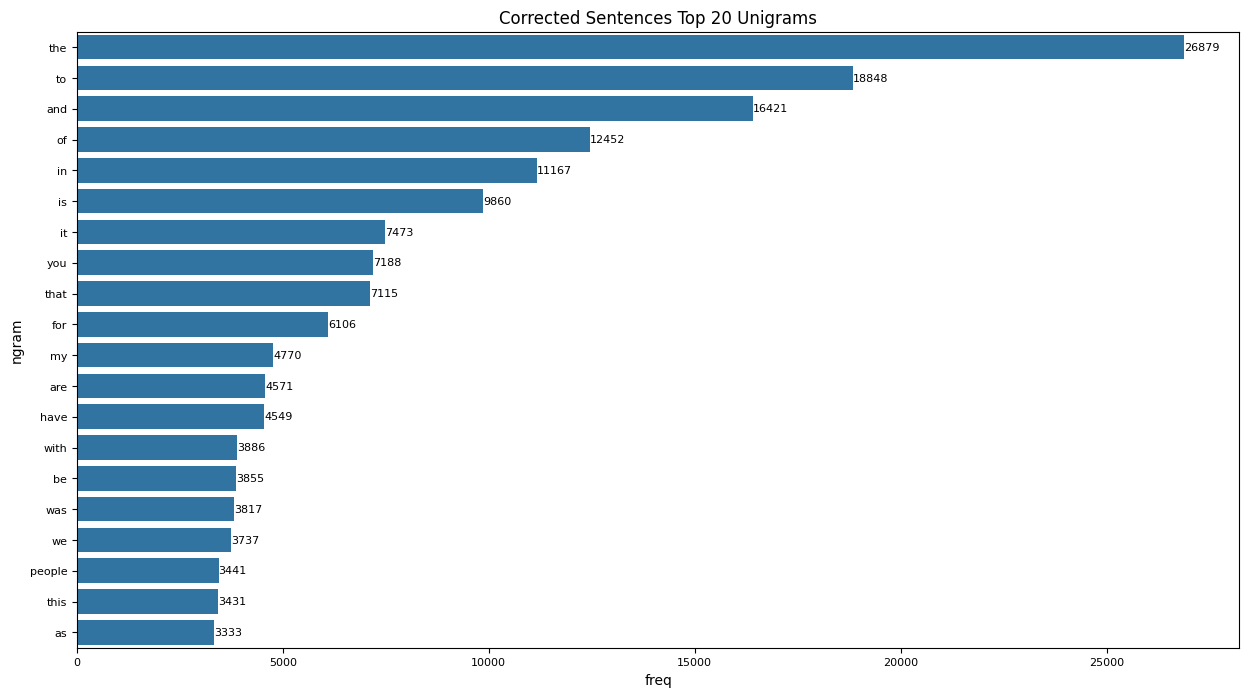

In [ ]:
train_corrected_unigram_df = get_ngram_freq(1, train_df["corrected"])
plot_ngram_freq(train_corrected_unigram_df, "Corrected Sentences Top 20 Unigrams", 20)

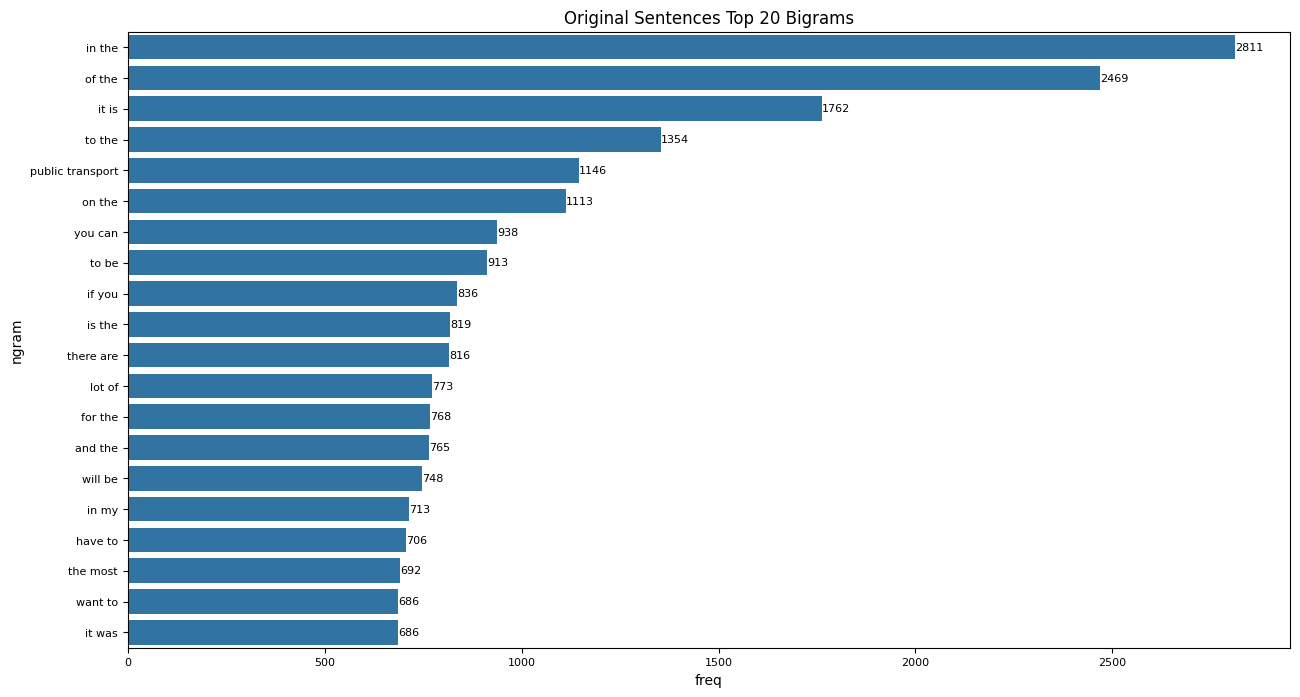

In [ ]:
train_ori_bigram_df = get_ngram_freq(2, train_df["original"])
plot_ngram_freq(train_ori_bigram_df, "Original Sentences Top 20 Bigrams", 20)

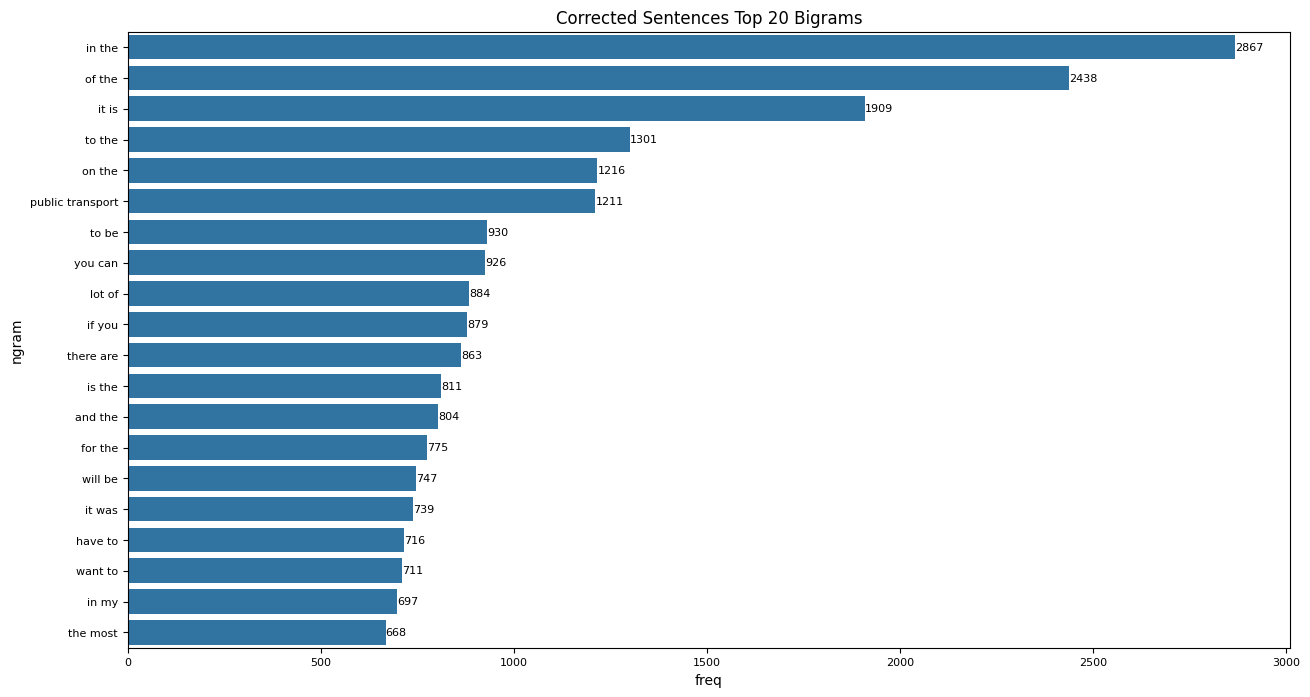

In [ ]:
train_corrected_bigram_df = get_ngram_freq(2, train_df["corrected"])
plot_ngram_freq(train_corrected_bigram_df, "Corrected Sentences Top 20 Bigrams", 20)

## Error Count

In [ ]:
def get_error_freq(n, errors):
    error_freq = defaultdict(int)
    for sent_errors in errors:
        for e in sent_errors:
            error_freq[e] += 1
    df = pd.DataFrame(error_freq.items(), columns=["error", "freq"])
    df = df.sort_values(by=["freq"],ascending=[False])
    return df

def plot_error_freq(df, title, top_n):
    df = df[:top_n]
    fig, ax = plt.subplots(figsize=(15, 8))
    ax = sns.barplot(data=df, x="freq", y="error")
    ax.tick_params(labelsize=8)
    for bar in ax.patches:
        ax.annotate(int(bar.get_width()), (bar.get_width(), bar.get_y() + bar.get_height()/2), size=8, ha="left", va="center")
    plt.title(title)
    plt.show()

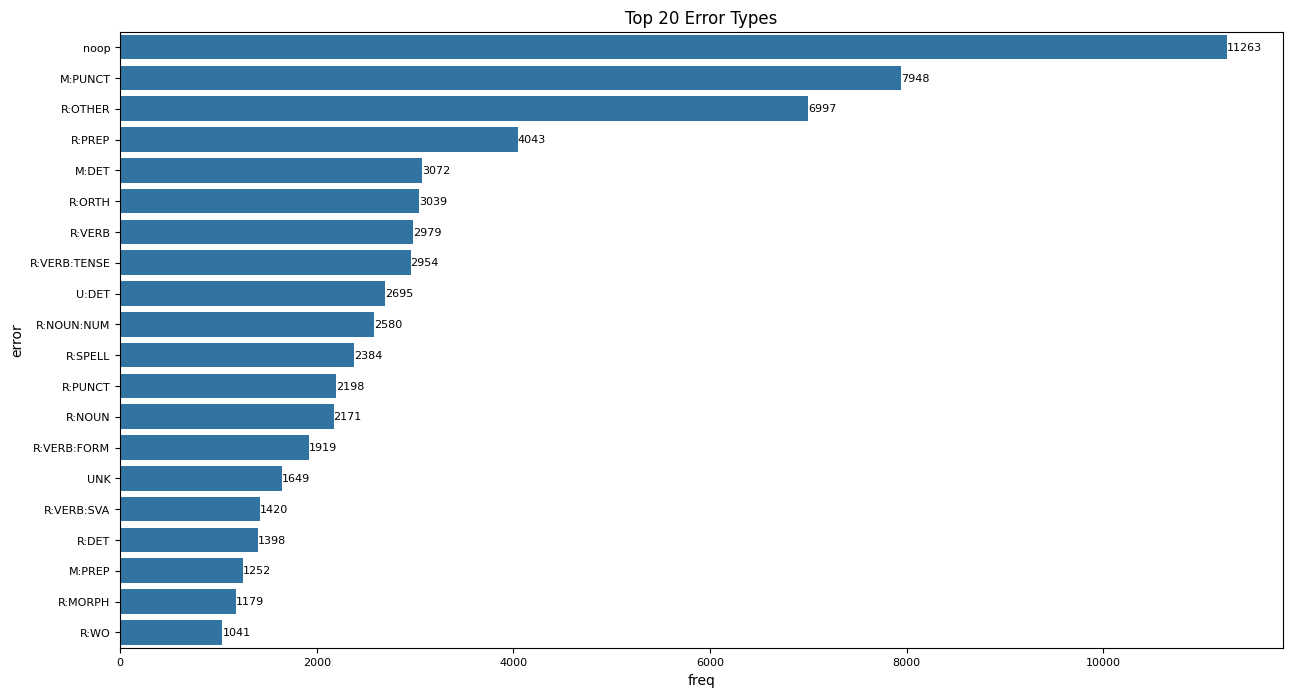

In [ ]:
train_error_df = get_error_freq(1, train_df["errors"])
plot_error_freq(train_error_df, "Top 20 Error Types", 20)

In [ ]:
train_df['error_count'] = train_df['errors'].astype("object").apply(lambda x:len(x))


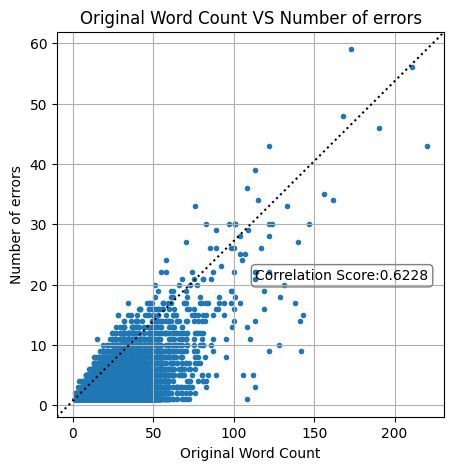

In [ ]:
# Plot number of words vs error counts
plot_scatter("Original Word Count VS Number of errors", train_df["original_word_count"], train_df['error_count'], "Original Word Count", "Number of errors")

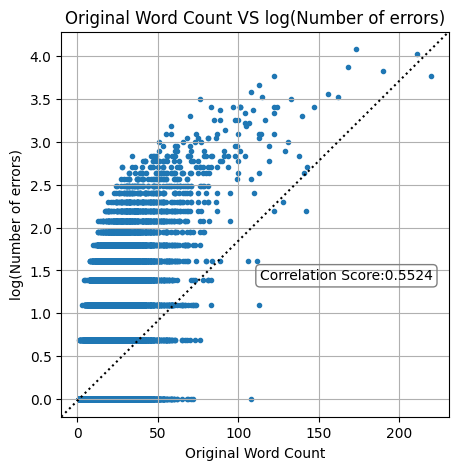

In [ ]:
# log graph since most number of errors are small
plot_scatter("Original Word Count VS log(Number of errors)", train_df["original_word_count"], train_df['error_count'].apply(np.log), "Original Word Count", "log(Number of errors)")

## Average number of errors

In [ ]:
train_df["errors_per_sentence"] = pd.DataFrame(list(map(len, train_df["errors"].tolist())))
train_df["errors_per_sentence"].describe()

count    34308.000000
mean         2.184505
std          2.277740
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         59.000000
Name: errors_per_sentence, dtype: float64